# SpaceX  Falcon 9 First Stage Landing Prediction


Predict if SpaceX's Falcon 9 rocket launch will result in a successful landing of the first stage. SpaceX advertises Falcon 9 rocket launches with a cost of 62 million dollars; other providers cost upward of 165 million dollars each. Much of SpaceX's savings come from the reuseability of the first stage. Therefore if it is determined that the first stage will land successfully, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against SpaceX for a rocket launch.

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import datetime

In [90]:
# Ensure that all collumns of a dataframe and all data for a given column are shown
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Collect Data into DataFrame

SpaceX rocket launch data is retrievable from a URl (REST API) with several endpoints.  

In [91]:
url = "https://api.spacexdata.com/v4/launches/past"

In [92]:
response = requests.get(url)

In [93]:
response.status_code

200

In [219]:
response.json()[0]

{'fairings': {'reused': False,
  'recovery_attempt': False,
  'recovered': False,
  'ships': []},
 'links': {'patch': {'small': 'https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png',
   'large': 'https://images2.imgbox.com/40/e3/GypSkayF_o.png'},
  'reddit': {'campaign': None,
   'launch': None,
   'media': None,
   'recovery': None},
  'flickr': {'small': [], 'original': []},
  'presskit': None,
  'webcast': 'https://www.youtube.com/watch?v=0a_00nJ_Y88',
  'youtube_id': '0a_00nJ_Y88',
  'article': 'https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html',
  'wikipedia': 'https://en.wikipedia.org/wiki/DemoSat'},
 'static_fire_date_utc': '2006-03-17T00:00:00.000Z',
 'static_fire_date_unix': 1142553600,
 'net': False,
 'window': 0,
 'rocket': '5e9d0d95eda69955f709d1eb',
 'success': False,
 'failures': [{'time': 33,
   'altitude': None,
   'reason': 'merlin engine failure'}],
 'details': 'Engine failure at 33 seconds and loss of vehicle',
 'crew': [],
 'ships': [],
 'caps

In [95]:
df = pd.json_normalize(response.json())

In [96]:
df.head()

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,capsules,payloads,launchpad,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,auto_update,tbd,launch_library_id,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png,https://images2.imgbox.com/40/e3/GypSkayF_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]","Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/4f/e3/I0lkuJ2e_o.png,https://images2.imgbox.com/be/e7/iNqsqVYM_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]",Residual stage 1 thrust led to collision between stage 1 and stage 2,[],[],[],"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]",5e9e4502f5090995de566f86,3,Trailblazer,2008-08-03T03:34:00.000Z,1217734440,2008-08-03T15:34:00+12:00,hour,False,"[{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdbffd86e000604b32c,False,False,False,[],https://images2.imgbox.com/3d/86/cnu0pan8_o.png,https://images2.imgbox.com/4b/bd/d8UxLh4q_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1-flight-3-mission-summary,https://en.wikipedia.org/wiki/Trailblazer_(satellite),NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,0.0,5e9d0d95eda69955f709d1eb,True,[],"Ratsat was carried to orbit on the first successful orbital launch of any privately funded and developed, liquid-propelled carrier rocket, the SpaceX Falcon 1",[],[],[],[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,4,RatSat,2008-09-28T23:15:00.000Z,1222643700,2008-09-28T11:15:00+12:00,hour,False,"[{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': 

## Define Functions for Updating DataFrame using API

Some of the columns (like rocket) have an ID, not actual data, so we need to use the API again to target another endpoint to gather specific data for each ID number. These functions are already created and the data will be stored in lists that we can use to create the dataset.

1) Create function that iterates through the rockets column and gets the rocket type (name as opposed to ID) from the rocket endpoint and stores the name in a list (BoosterVersion)

In [97]:
df["rocket"].head()

0    5e9d0d95eda69955f709d1eb
1    5e9d0d95eda69955f709d1eb
2    5e9d0d95eda69955f709d1eb
3    5e9d0d95eda69955f709d1eb
4    5e9d0d95eda69955f709d1eb
Name: rocket, dtype: object

In [98]:
def getBoosterVersion(data):
    for x in df["rocket"]:
        rockets_response = requests.get("https://api.spacexdata.com/v4/rockets/" + str(x)).json()
        BoosterVersion.append(rockets_response["name"])

2) Create function that iterates through the launchpad column and gets the longitude, latitude, and name from the launchpad endpoint and stores them in lists (Longitude, Latitude, LaunchSite)

In [99]:
df["launchpad"].head()

0    5e9e4502f5090995de566f86
1    5e9e4502f5090995de566f86
2    5e9e4502f5090995de566f86
3    5e9e4502f5090995de566f86
4    5e9e4502f5090995de566f86
Name: launchpad, dtype: object

In [100]:
def getLaunchSite(data):
    for x in df["launchpad"]:
        launchpads_response = requests.get("https://api.spacexdata.com/v4/launchpads/" + str(x)).json()
        Longitude.append(launchpads_response["longitude"])
        Latitude.append(launchpads_response["latitude"])
        LaunchSite.append(launchpads_response["name"])

3) Create function that iterates through the payloads column and gets the payload mass and orbit from the payloads endpoint and stores them in lists (PayloadMass, Orbit)

In [101]:
df["payloads"][1]

['5eb0e4b6b6c3bb0006eeb1e2']

In [102]:
def getPayloadData(data):
    for load in df["payloads"]:
        payloads_response = requests.get("https://api.spacexdata.com/v4/payloads/" + load).json()
        PayloadMass.append(payloads_response["mass_kg"])
        Orbit.append(payloads_response["orbit"])

4) Create function that iterates through the cores column and gets the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core from the cores endpoint and stores them in lists 

In [103]:
df["cores"][10]

[{'core': '5e9e289ff359180ae23b262d',
  'flight': 1,
  'gridfins': False,
  'legs': False,
  'reused': False,
  'landing_attempt': True,
  'landing_success': False,
  'landing_type': 'Ocean',
  'landpad': None}]

In [104]:
for core in df["cores"][10]:
    print(core["core"])

5e9e289ff359180ae23b262d


In [105]:
def getCoreData(data):
    for core in df["cores"]:
        if core["core"] != None:
            cores_response = requests.get("https://api.spacexdata.com/v4/cores/" + core["core"]).json()
            Block.append(cores_response["block"])
            ReusedCount.append(cores_response["reuse_count"])
            Serial.append(cores_response["serial"])
        else:
            Block.append(None)
            ReusedCount.append(None)
            Serial.append(None)
        Outcome.append(str(core["landing_success"]) + ' ' + str(core["landing_type"]))
        Flights.append(core["flight"])
        GridFins.append(core["gridfins"])
        Reused.append(core["reused"])
        Legs.append(core["legs"])
        LandingPad.append(core["landpad"])

## Update DataFrame

In [106]:
# Update DataFrame to only contain the useful columns
df = df[["rocket", "payloads", "launchpad", "cores", "flight_number", "date_utc"]]
df.head()

,rocket,payloads,launchpad,cores,flight_number,date_utc
0,5e9d0d95eda69955f709d1eb,[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",1,2006-03-24T22:30:00.000Z
1,5e9d0d95eda69955f709d1eb,[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",2,2007-03-21T01:10:00.000Z
2,5e9d0d95eda69955f709d1eb,"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]",5e9e4502f5090995de566f86,"[{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",3,2008-08-03T03:34:00.000Z
3,5e9d0d95eda69955f709d1eb,[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,"[{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",4,2008-09-28T23:15:00.000Z
4,5e9d0d95eda69955f709d1eb,[5eb0e4b7b6c3bb0006eeb1e6],5e9e4502f5090995de566f86,"[{'core': '5e9e289ef359184f103b2627', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5,2009-07-13T03:35:00.000Z


In [107]:
# Remove rows with multiple cores or multiple payloads
df = df[df["cores"].map(len) == 1]
df = df[df["payloads"].map(len) == 1]

In [108]:
# Create a date column that only includes the date (no time) from the date_utc column
df["date"] = pd.to_datetime(df["date_utc"]).dt.date
df = df[df["date"] <= datetime.date(2020, 11, 13)]

In [109]:
# Convert cores and payloads columns from a dict within a list to a dict
df["cores"] = df["cores"].map(lambda x: x[0])
df["payloads"] = df["payloads"].map(lambda x: x[0])

In [110]:
df.head()

,rocket,payloads,launchpad,cores,flight_number,date_utc,date
0,5e9d0d95eda69955f709d1eb,5eb0e4b5b6c3bb0006eeb1e1,5e9e4502f5090995de566f86,"{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",1,2006-03-24T22:30:00.000Z,2006-03-24
1,5e9d0d95eda69955f709d1eb,5eb0e4b6b6c3bb0006eeb1e2,5e9e4502f5090995de566f86,"{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",2,2007-03-21T01:10:00.000Z,2007-03-21
3,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e5,5e9e4502f5090995de566f86,"{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",4,2008-09-28T23:15:00.000Z,2008-09-28
4,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e6,5e9e4502f5090995de566f86,"{'core': '5e9e289ef359184f103b2627', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",5,2009-07-13T03:35:00.000Z,2009-07-13
5,5e9d0d95eda69973a809d1ec,5eb0e4b7b6c3bb0006eeb1e7,5e9e4501f509094ba4566f84,"{'core': '5e9e289ef359185f2b3b2628', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",6,2010-06-04T18:45:00.000Z,2010-06-04


## Create New DataFrame

*   From the <code>rocket</code> we would like to learn the booster name

*   From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to

*   From the <code>launchpad</code> we would like to know the name of the launch site being used, the longitude, and the latitude.

*   From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

The data from these requests will be stored in lists and will be used to create a new dataframe.

In [111]:
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [112]:
getBoosterVersion(df)
getLaunchSite(df)
getPayloadData(df)
getCoreData(df)

In [113]:
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

In [114]:
launch_dict = {
    'FlightNumber' : list(df['flight_number']),
    'Date' : list(df['date']),
    'BoosterVersion' : BoosterVersion,
    'PayloadMass' : PayloadMass,
    'Orbit' : Orbit,
    'LaunchSite' : LaunchSite,
    'Outcome' : Outcome,
    'Flights' : Flights,
    'GridFins' : GridFins,
    'Reused' : Reused,
    'Legs' : Legs,
    'LandingPad' : LandingPad,
    'Block' : Block,
    'ReusedCount' : ReusedCount,
    'Serial' : Serial,
    'Longitude' : Longitude,
    'Latitude' : Latitude}

In [115]:
df_launch = pd.DataFrame.from_dict(launch_dict) 

In [116]:
df_launch.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


## Data Wrangling

#### Dealing with Useless and Null Values

* Filter data to only include Falcon 9 launches
* Replace null values in the PayloadMass column with the mean of the column
* Leave the LandingPad null values (they represent when a landing pad is not used)

In [117]:
df_launch["BoosterVersion"].value_counts()

Falcon 9    90
Falcon 1     4
Name: BoosterVersion, dtype: int64

In [118]:
df_f9 = df_launch[df_launch["BoosterVersion"] == "Falcon 9"]
df_f9["BoosterVersion"].value_counts()

Falcon 9    90
Name: BoosterVersion, dtype: int64

In [119]:
df_f9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,8,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,10,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,12,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


In [120]:
# Reset FlightNumer column
df_f9.loc[:,"FlightNumber"] = list(range(1, df_f9.shape[0] + 1))
df_f9.head()

C:\Users\ikant\anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


In [121]:
df_launch.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        6
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        30
Block              4
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [122]:
mass_mean = df_f9["PayloadMass"].mean(axis = 0)
mass_mean

6123.547647058824

In [123]:
df_f9["PayloadMass"].replace(np.nan, mass_mean, inplace = True)
df_f9.isnull().sum()

C:\Users\ikant\anaconda3\lib\site-packages\pandas\core\series.py:4576: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [124]:
df_f9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


In [125]:
df_f9.to_csv("Practice_CSV_1", index = False)

#### Converting Outcomes into Numerical Training Labels

Convert outcomes into training labels with `1` meaning the booster successfully landed and `0` meaning it was unsuccessful.
*     <code>True Ocean</code> means the mission outcome was successfully  landed to a specific region of the ocean
*     <code>False Ocean</code> means the mission outcome was unsuccessfully landed to a specific region of the ocean.
*     <code>True RTLS</code> means the mission outcome was successfully  landed to a ground pad 
*     <code>False RTLS</code> means the mission outcome was unsuccessfully landed to a ground pad.
*     <code>True ASDS</code> means the mission outcome was successfully landed on a drone ship 
*     <code>False ASDS</code> means the mission outcome was unsuccessfully landed on a drone ship.

In [126]:
df_f9.reset_index(drop = True, inplace = True)
df_f9.head(10)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
5,6,2014-01-06,Falcon 9,3325.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1005,-80.577366,28.561857
6,7,2014-04-18,Falcon 9,2296.000000,ISS,CCSFS SLC 40,True Ocean,1,False,False,True,None,1.0,0,B1006,-80.577366,28.561857
7,8,2014-07-14,Falcon 9,1316.000000,LEO,CCSFS SLC 40,True Ocean,1,False,False,True,None,1.0,0,B1007,-80.577366,28.561857
8,9,2014-08-05,Falcon 9,4535.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1008,-80.577366,28.561857
9,10,2014-09-07,Falcon 9,4428.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1011,-80.577366,28.561857


In [127]:
landing_outcomes = df_f9["Outcome"].value_counts()
landing_outcomes

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
None ASDS       2
False Ocean     2
False RTLS      1
Name: Outcome, dtype: int64

In [128]:
print(landing_outcomes.keys())
print("")
for key, outcome in enumerate(landing_outcomes.keys()):
    print(key, outcome)

Index(['True ASDS', 'None None', 'True RTLS', 'False ASDS', 'True Ocean',
       'None ASDS', 'False Ocean', 'False RTLS'],
      dtype='object')

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 None ASDS
6 False Ocean
7 False RTLS


In [129]:
failures = set(landing_outcomes.keys()[[1, 3, 5, 6, 7]])
failures

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [130]:
success = set(landing_outcomes.keys()[[0, 2, 4]])
success

{'True ASDS', 'True Ocean', 'True RTLS'}

In [131]:
class_list = []

for row in df_f9["Outcome"]:
    if row in failures:
        class_list.append(0)
    elif row in success:
        class_list.append(1)
    else:
        class_list.append(0)

class_list[0:10]

[0, 0, 0, 0, 0, 0, 1, 1, 0, 0]

In [132]:
df_f9["Class"] = class_list
df_f9.head()

C:\Users\ikant\AppData\Local\Temp/ipykernel_14372/3342039864.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0


In [133]:
# Determine landing success rate
print(str(round(df_f9["Class"].mean(), 3) * 100) + "%")

66.7%


In [134]:
df_f9.to_csv("Practice_CSV_2", index = False)

## Exploratory Data Analysis

Use EDA to determine which features of the dataset are worth incorporating into a predictive model of landing success  

In [135]:
df_f9.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
Class               int64
dtype: object

#### Date (Year)

In [136]:
df_f9["Date"] = pd.to_datetime(df_f9["Date"])
df_f9.dtypes

C:\Users\ikant\AppData\Local\Temp/ipykernel_14372/759688643.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



FlightNumber               int64
Date              datetime64[ns]
BoosterVersion            object
PayloadMass              float64
Orbit                     object
LaunchSite                object
Outcome                   object
Flights                    int64
GridFins                    bool
Reused                      bool
Legs                        bool
LandingPad                object
Block                    float64
ReusedCount                int64
Serial                    object
Longitude                float64
Latitude                 float64
Class                      int64
dtype: object

In [137]:
yearly_success = df_f9.groupby(df_f9.Date.dt.year)["Class"].mean()
yearly_success = yearly_success.values

In [138]:
years = []

for year in range(2010, 2020):
    years.append(year)

years = np.array(years)

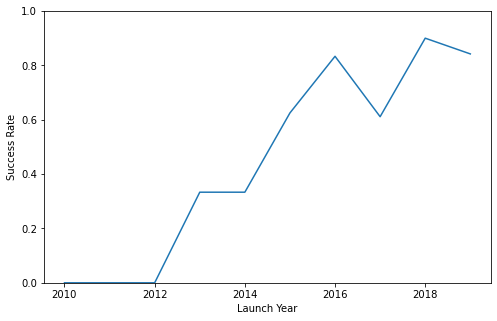

In [139]:
# Average Yearly Success Rate
plt.figure(figsize=(8,5))
sns.lineplot(x = years, y = yearly_success)
plt.xlabel("Launch Year")
plt.ylabel("Success Rate")
plt.ylim(0, 1)
plt.show()

Later years appear to have higher success rates

#### LaunchSite

In [140]:
launchsite_success = df_f9.groupby("LaunchSite")["Class"].mean()
launchsite_success = launchsite_success.values
launchsite_success

array([0.6       , 0.77272727, 0.76923077])

In [141]:
launchsites = df_f9["LaunchSite"].unique()
launchsites

array(['CCSFS SLC 40', 'VAFB SLC 4E', 'KSC LC 39A'], dtype=object)

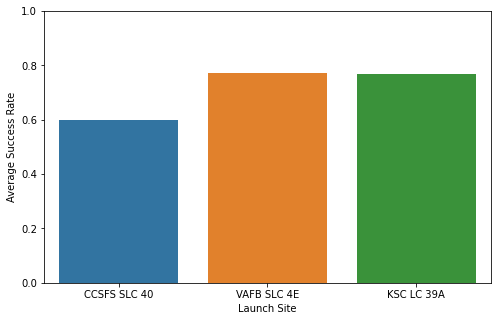

In [142]:
plt.figure(figsize=(8,5))
sns.barplot(x = launchsites, y = launchsite_success)
plt.xlabel("Launch Site")
plt.ylabel("Average Success Rate")
plt.ylim(0, 1)

plt.show()

In [143]:
df_f9["LaunchSite"].value_counts()

CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

CCSFS appears to have the lowest success rate, but the other launch sites also have fewer launches to sample from

#### PayloadMass and LaunchSite

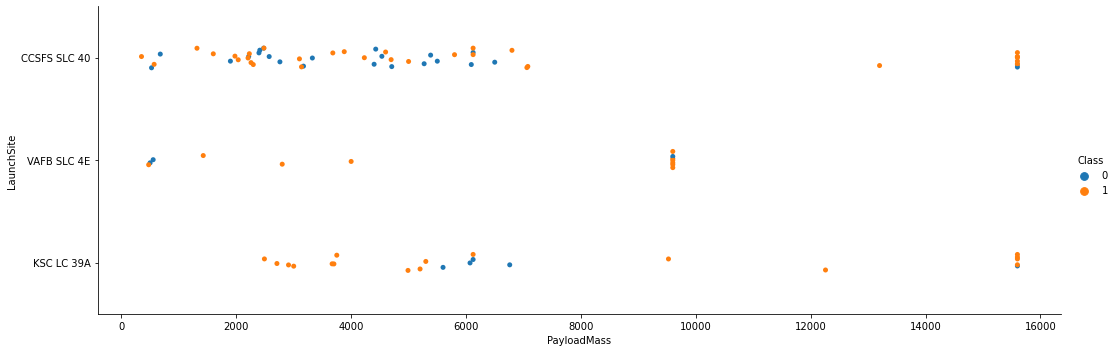

In [144]:
sns.catplot(data = df_f9, x = "PayloadMass", y = "LaunchSite", hue = "Class", aspect = 3)

Heavier payload masses, particularly those above 9000kg, appear to have a higher success rate, regardless of launch site 

#### FlightNumber and PayloadMass

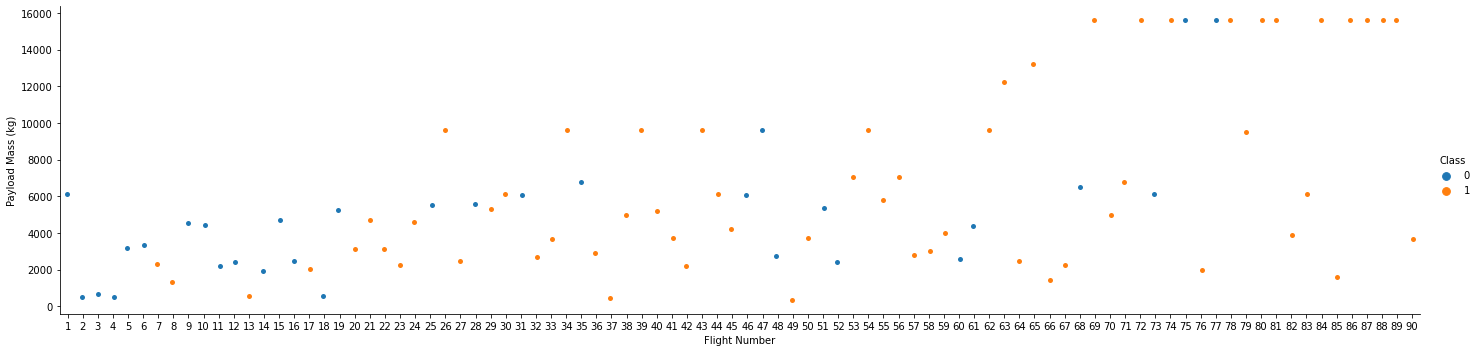

In [145]:
sns.catplot(data = df_f9, x = "FlightNumber", y = "PayloadMass", hue = "Class", aspect = 4)
plt.xlabel("Flight Number")
plt.ylabel("Payload Mass (kg)")
plt.show()

Higher flight numbers (later flights) appear to have heavier payload masses and higher success rates, so it is possible that the newer launches had heavier payload masses, which was a large contributor to success

#### Orbits 

In [146]:
orbit_success_rate = df_f9.groupby("Orbit")["Class"].mean()
orbit_success_rate

Orbit
ES-L1    1.000000
GEO      1.000000
GTO      0.518519
HEO      1.000000
ISS      0.619048
LEO      0.714286
MEO      0.666667
PO       0.666667
SO       0.000000
SSO      1.000000
VLEO     0.857143
Name: Class, dtype: float64

In [147]:
orbit_array = np.array(orbit_success_rate.keys())
orbit_array

array(['ES-L1', 'GEO', 'GTO', 'HEO', 'ISS', 'LEO', 'MEO', 'PO', 'SO',
       'SSO', 'VLEO'], dtype=object)

In [148]:
orbit_success_rate_array = orbit_success_rate.values
orbit_success_rate_array

array([1.        , 1.        , 0.51851852, 1.        , 0.61904762,
       0.71428571, 0.66666667, 0.66666667, 0.        , 1.        ,
       0.85714286])

Text(0, 0.5, 'Landing Success Rate')

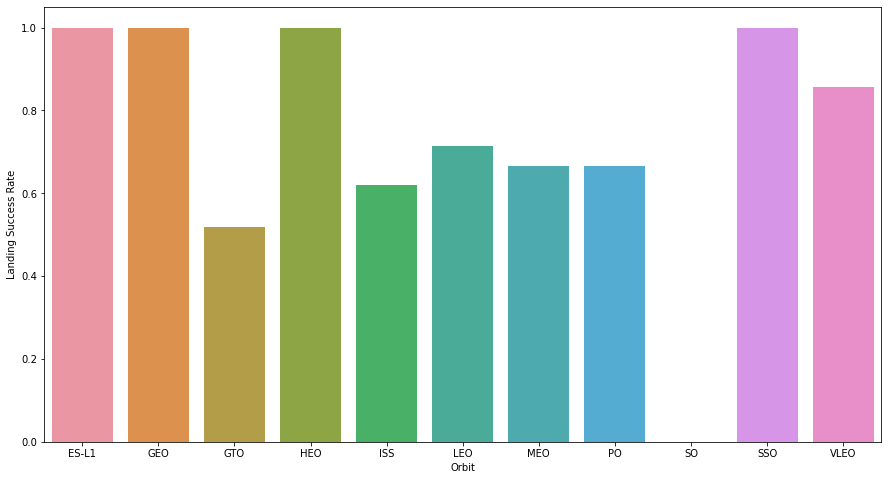

In [149]:
plt.figure(figsize=(15,8))
sns.barplot(x = orbit_array, y = orbit_success_rate_array)
plt.xlabel("Orbit")
plt.ylabel("Landing Success Rate")

On average, it apepars higher altitude orbits appear to have higher success rates

#### FlightNumber and Orbit

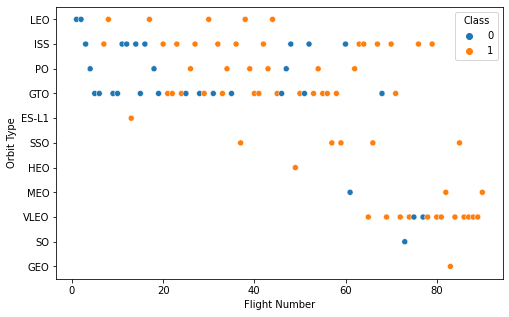

In [150]:
plt.figure(figsize=(8,5))
sns.scatterplot(data = df_f9, x = "FlightNumber", y = "Orbit", hue = "Class")
plt.xlabel("Flight Number")
plt.ylabel("Orbit Type")
plt.show()

Higher flight numbers tend to have higher orbital altitudes, which may mean that the success of higher altitude orbits was a function of later flights

#### PayloadMass and Orbit

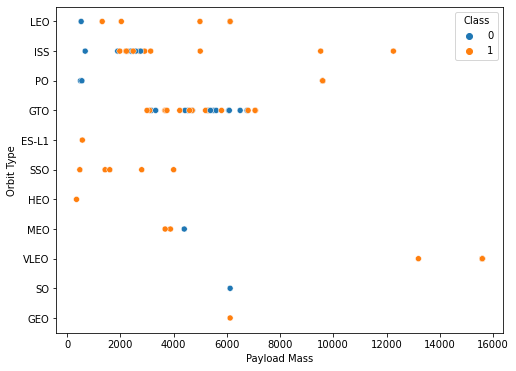

In [151]:
plt.figure(figsize = (8, 6))
sns.scatterplot(data = df_f9, x = "PayloadMass", y = "Orbit", hue = "Class")
plt.xlabel("Payload Mass")
plt.ylabel("Orbit Type")
plt.show()

Lower orbit launches seem to have lower payload masses, and the higher success launchs appears to be more related to having heavier payloads than certain orbits 

#### Date and FlightNumber

<AxesSubplot:xlabel='Date', ylabel='FlightNumber'>

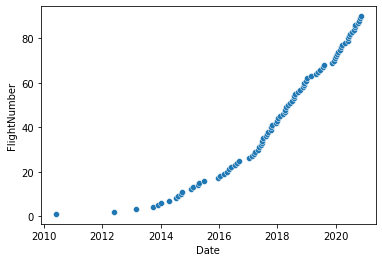

In [152]:
sns.scatterplot(data = df_f9, x = "Date", y = "FlightNumber")

In [153]:
import plotly.express as px

In [154]:
def get_pie_chart(entered_site):
    filtered_df = df_f9[df_f9["LaunchSite"] == entered_site]
    if entered_site == "ALL":
        fig = px.pie(df_f9, values = "Class", names = "LaunchSite", title = "Total Successful Launches by Site")
        return fig
    else:
        fig = px.pie(filtered_df, names = "Class", title = "Total Successful Launches for site " + entered_site)
        return fig

entered_site = df_f9["LaunchSite"].unique()[2]
get_pie_chart(entered_site)

## Feature Engineering

In [155]:
df_f9.columns

Index(['FlightNumber', 'Date', 'BoosterVersion', 'PayloadMass', 'Orbit',
       'LaunchSite', 'Outcome', 'Flights', 'GridFins', 'Reused', 'Legs',
       'LandingPad', 'Block', 'ReusedCount', 'Serial', 'Longitude', 'Latitude',
       'Class'],
      dtype='object')

In [156]:
features = ["FlightNumber", "PayloadMass", "Orbit", "LaunchSite", "Flights", "GridFins",
            "Reused", "Legs", "LandingPad", "Block", "ReusedCount", "Serial"]

In [157]:
df_features = df_f9[features]
df_features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
1,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
2,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
4,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


#### Create Dummy Variables for Categorical Values

In [158]:
df_features.dtypes

FlightNumber      int64
PayloadMass     float64
Orbit            object
LaunchSite       object
Flights           int64
GridFins           bool
Reused             bool
Legs               bool
LandingPad       object
Block           float64
ReusedCount       int64
Serial           object
dtype: object

Use one-hot encoding to create dummy variables for <code>Orbit</code>, <code>LaunchSite</code>, <code>LandingPad</code>, and <code>Serial</code>

In [159]:
df_features = pd.get_dummies(df_features, columns = ["Orbit", "LaunchSite", "LandingPad", "Serial", "GridFins", "Reused", "Legs"])

In [160]:
len(df_features.columns)

83

In [161]:
df_features.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1,6123.547647,1,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
1,2,525.000000,1,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
2,3,677.000000,1,1.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
3,4,500.000000,1,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
4,5,3170.000000,1,1.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0


In [162]:
df_features.shape

(90, 83)

#### Convert all numeric columns to float

In [163]:
df_features = df_features.astype("float64")

In [164]:
df_features.dtypes

FlightNumber     float64
PayloadMass      float64
Flights          float64
Block            float64
ReusedCount      float64
                  ...   
GridFins_True    float64
Reused_False     float64
Reused_True      float64
Legs_False       float64
Legs_True        float64
Length: 83, dtype: object

In [165]:
df_features.to_csv("Practive_CSV_3", index = False)

## ML Predictive Model Development

In [166]:
df_features.describe()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,45.500000,6123.547647,1.788889,3.500000,3.144444,0.011111,0.011111,0.300000,0.011111,0.233333,0.077778,0.033333,0.100000,0.011111,0.055556,0.155556,0.611111,0.244444,0.144444,0.144444,0.022222,0.388889,0.022222,0.133333,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.022222,0.011111,0.011111,0.011111,0.011111,0.011111,0.022222,0.011111,0.022222,0.022222,0.011111,0.022222,0.022222,0.011111,0.011111,0.022222,0.022222,0.022222,0.011111,0.011111,0.011111,0.022222,0.044444,0.033333,0.044444,0.066667,0.011111,0.055556,0.011111,0.044444,0.033333,0.044444,0.033333,0.011111,0.222222,0.777778,0.588889,0.411111,0.211111,0.788889
std,26.124701,4732.115291,1.213172,1.595288,4.106890,0.105409,0.105409,0.460825,0.105409,0.425322,0.269322,0.180511,0.301681,0.105409,0.230345,0.364464,0.490229,0.432165,0.353509,0.353509,0.148231,0.490229,0.148231,0.341839,0.105409,0.105409,0.105409,0.105409,0.105409,0.105409,0.105409,0.105409,0.105409,0.105409,0.105409,0.105409,0.105409,0.105409,0.105409,0.105409,0.105409,0.105409,0.105409,0.148231,0.105409,0.105409,0.105409,0.105409,0.105409,0.148231,0.105409,0.148231,0.148231,0.105409,0.148231,0.148231,0.105409,0.105409,0.148231,0.148231,0.148231,0.105409,0.105409,0.105409,0.148231,0.207235,0.180511,0.207235,0.250841,0.105409,0.230345,0.105409,0.207235,0.180511,0.207235,0.180511,0.105409,0.418069,0.418069,0.494792,0.494792,0.410383,0.410383
min,1.000000,350.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

#### Preprocessing

Create numpy array of independent variables to be assigned as <code>X</code>

In [167]:
X = df_features

In [168]:
X.shape

(90, 83)

Create numpy array of the dependent variable, <code>Class</code>, to be assigned as <code>Y</code>

In [169]:
Y = df_f9["Class"].to_numpy()
Y[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

Standardize <code>X</code> (all the independent variables)

In [170]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit(X).transform(X)
X[0]

array([-1.71291154,  0.        , -0.65391284, -1.57589457, -0.76994048,
       -0.10599979, -0.10599979, -0.65465367, -0.10599979, -0.55167728,
        3.44342023, -0.18569534, -0.33333333, -0.10599979, -0.24253563,
       -0.42919754,  0.79772404, -0.56879646, -0.4108907 , -0.4108907 ,
       -0.15075567, -0.79772404, -0.15075567, -0.39223227,  9.43398113,
       -0.10599979, -0.10599979, -0.10599979, -0.10599979, -0.10599979,
       -0.10599979, -0.10599979, -0.10599979, -0.10599979, -0.10599979,
       -0.10599979, -0.10599979, -0.10599979, -0.10599979, -0.10599979,
       -0.10599979, -0.10599979, -0.10599979, -0.15075567, -0.10599979,
       -0.10599979, -0.10599979, -0.10599979, -0.10599979, -0.15075567,
       -0.10599979, -0.15075567, -0.15075567, -0.10599979, -0.15075567,
       -0.15075567, -0.10599979, -0.10599979, -0.15075567, -0.15075567,
       -0.15075567, -0.10599979, -0.10599979, -0.10599979, -0.15075567,
       -0.21566555, -0.18569534, -0.21566555, -0.26726124, -0.10

Split the data into traning and testing sets

In [171]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2)

In [172]:
print(y_train.shape)
print(y_test.shape)
y_test.shape[0] / y_train.shape[0]

(72,)
(18,)


0.25

#### Logistic Regression

Prepare parameters for Grid Search, which will be used to determine the optimal hyperparameters

In [173]:
parameters = {"C" : [0.01, 0.1, 1],
             "penalty" : ["l2"],
             "solver" : ["lbfgs"]}

Create Logistic Regression object

In [174]:
from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression()

Use Grid Search to find the best parameters and accuracy on validation data for the Logistic Regression object

In [175]:
from sklearn.model_selection import GridSearchCV
LogRegCV = GridSearchCV(LogReg, parameters, cv = 5).fit(x_train, y_train)

print("Best parameters:", LogRegCV.best_params_)
print("Logistic Regression Accuracy:", LogRegCV.best_score_)

Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression Accuracy: 0.8342857142857143


Evaluate the model's accuracy with the optimized hyperparameters

In [177]:
LogReg_Acc = LogRegCV.score(x_test, y_test)
print("Accuracy =", LogReg_Acc)

Accuracy = 0.8333333333333334


Create Confusion Matrix to evaluation accuracy

In [178]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y, y_predict):
    cm = confusion_matrix(y, y_predict)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

In [179]:
yhat_LogReg = LogRegCV.predict(x_test)
yhat_LogReg[0:5]

array([1, 1, 1, 1, 1], dtype=int64)

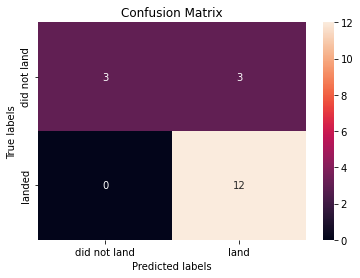

In [180]:
plot_confusion_matrix(y_test, yhat_LogReg)

Confusion Matrix shows that the Logistic Regression model is accurate, with the biggest prediction problem being False Positives (predicting land when actuals did not land)

In [181]:
from sklearn.metrics import f1_score
f1_LogReg = f1_score(y_test, yhat_LogReg)
print("f1 score =", f1_LogReg)

f1 score = 0.888888888888889


#### Support Vector Machine (SVM)

Repeat modeling and evaluation for SVM

In [182]:
parameters1 = {"C" : np.logspace(-3, 3, 5), # regularization strength (np.logspace returns evenly spaced numbers on log scale)
              "kernel" : ("linear", "poly", "rbf", "sigmoid"),
              "gamma" : np.logspace(-3, 3, 5)} # kernel coefficient (np.logspace returns evenly spaced numbers on log scale)

In [183]:
from sklearn import svm
SVM = svm.SVC()

In [184]:
SVM_CV = GridSearchCV(SVM, parameters1, cv = 5).fit(x_train, y_train)

In [185]:
print("Best parameter =", SVM_CV.best_params_)
print("Best SVM Accuracy =", SVM_CV.best_score_)

Best parameter = {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
Best SVM Accuracy = 0.8476190476190476


In [188]:
SVM_Acc = SVM_CV.score(x_test, y_test)
print("Accuracy =", SVM_Acc)

Accuracy = 0.8333333333333334


In [189]:
yhat_SVM = SVM_CV.predict(x_test)
yhat_SVM[0:5]

array([1, 1, 1, 1, 1], dtype=int64)

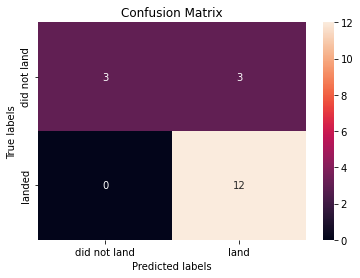

In [190]:
plot_confusion_matrix(y_test, yhat_SVM)

Confusion Matrix shows that the SVM model is accurate, with the biggest prediction problem being False Positives (same results as Logistic Regression)

In [191]:
f1_SVM = f1_score(y_test, yhat_SVM)
print("f1 score =", f1_SVM)

f1 score = 0.888888888888889


#### Decision Tree

Repeat modeling and evaluation for a decision tree

In [192]:
parameters2 = {"criterion" : ["gini", "entropy"], # function to measure quality of a split
               "max_depth" : np.linspace(2, 20, 10).tolist(), # maximum depth of the tree
               "splitter" : ["best", "random"], # strategy for choosing split at each node
               "max_features" : ["auto", "sqrt"], # number of features to consider when looking for best split
               "min_samples_leaf" : [1, 2, 4], # minimum number of samples required to be at a leaf node
               "min_samples_split" : [2, 5, 10]} # minimum number of samples required to split an internal node

In [193]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()

In [194]:
tree_CV = GridSearchCV(tree, parameters2, cv = 5).fit(x_train, y_train)

In [195]:
print("Best hyperparameters =", tree_CV.best_params_)
print("Best Accuracy =", tree_CV.best_score_)

Best hyperparameters = {'criterion': 'entropy', 'max_depth': 10.0, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
Best Accuracy = 0.9019047619047619


In [196]:
tree_Acc = tree_CV.score(x_test, y_test)
print("Accuracy =", tree_Acc)

Accuracy = 0.8888888888888888


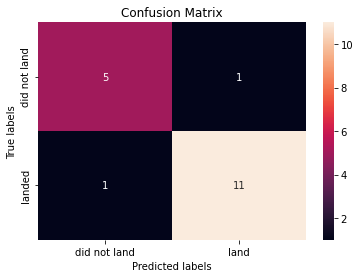

In [197]:
yhat_tree = tree_CV.predict(x_test)
plot_confusion_matrix(y_test, yhat_tree)

The Confusion Matrix shows that this Decision Tree model provides nearly perfect prediction accuracy on the testing set, with no False Negatives and only one False Positive

In [198]:
f1_tree = f1_score(y_test, yhat_tree)
print("f1 score =", f1_tree)

f1 score = 0.9166666666666666


#### K-Nearest Neighbors (KNN)

Repeat modeling and evaluation for KNN

In [199]:
parameters3 = {"n_neighbors" : list(range(1, 11)), # number of neighbors to use for prediction
             "algorithm" : ["auto", "ball_tree", "kd_tree", "brute"], # algorithm used to compute the nearest neighbors
             "p" : [1, 2]} # power parameter for the Minkowski metric (generalization of Euclidean and Manhattan distance)

In [200]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier()

In [201]:
KNN_CV = GridSearchCV(KNN, parameters3, cv = 5).fit(x_train, y_train)

In [202]:
print("Best hyperparameters =", KNN_CV.best_params_)
print("Best Accuracy =", KNN_CV.best_score_)

Best hyperparameters = {'algorithm': 'auto', 'n_neighbors': 8, 'p': 1}
Best Accuracy = 0.8609523809523811


In [205]:
KNN_Acc = KNN_CV.score(x_test, y_test)
print("Accuracy =", KNN_Acc)

Accuracy = 0.8333333333333334


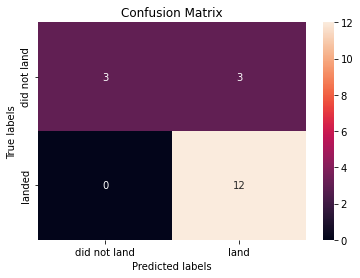

In [206]:
yhat_KNN = KNN_CV.predict(x_test)
plot_confusion_matrix(y_test, yhat_KNN)

Confusion Matrix shows that the KNN model is accurate, with the biggest prediction problem being False Positives (same results as Logistic Regression and SVM)

In [207]:
f1_KNN = f1_score(y_test, yhat_KNN)
print("f1 score =", f1_KNN)

f1 score = 0.888888888888889


#### Model Comparison

Accuracy

In [208]:
print("Logistic Regression:", LogReg_Acc)
print("Support Vector Machine:", SVM_Acc)
print("Decision Tree:", tree_Acc)
print("K-Nearest Neighbors:", KNN_Acc)

Logistic Regression: 0.8333333333333334
Support Vector Machine: 0.8333333333333334
Decision Tree: 0.8888888888888888
K-Nearest Neighbors: 0.8333333333333334


In [209]:
acc_bar_dict = {"Logistic Regression" : LogReg_Acc,
            "Support Vector Machine" : SVM_Acc,
            "Decision Tree" : tree_Acc,
            "K-Nearest Neighbor" : KNN_Acc}

Text(0, 0.5, 'Accuracy')

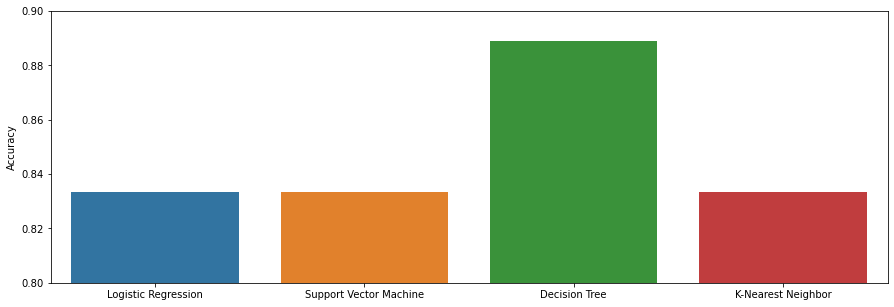

In [214]:
fig = plt.figure(figsize=(15,5))
sns.barplot(x = list(acc_bar_dict.keys()), y = list(acc_bar_dict.values()))
plt.ylim(0.8, 0.9)
plt.ylabel("Accuracy")

F1 score

In [211]:
print("Logistic Regression:", f1_LogReg)
print("Support Vector Machine:", f1_SVM)
print("Decision Tree:", f1_tree)
print("K-Nearest Neighbors:", f1_KNN)

Logistic Regression: 0.888888888888889
Support Vector Machine: 0.888888888888889
Decision Tree: 0.9166666666666666
K-Nearest Neighbors: 0.888888888888889


In [212]:
f1_bar_dict = {"Logistic Regression" : f1_LogReg,
            "Support Vector Machine" : f1_SVM,
            "Decision Tree" : f1_tree,
            "K-Nearest Neighbor" : f1_KNN}

Text(0, 0.5, 'F1 Score')

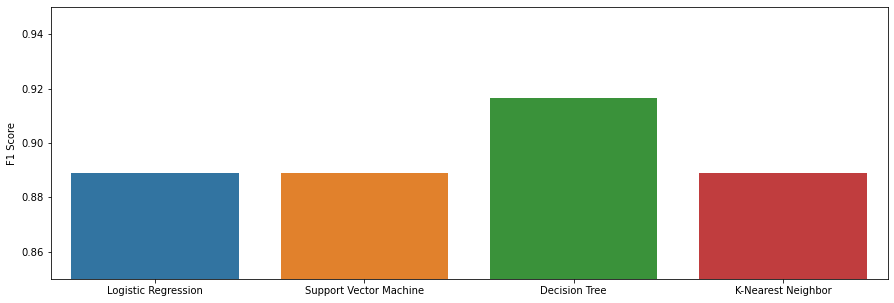

In [216]:
fig = plt.figure(figsize=(15,5))
sns.barplot(x = list(f1_bar_dict.keys()), y = list(f1_bar_dict.values()))
plt.ylim(0.85, 0.95)
plt.ylabel("F1 Score")

*Each classification machine learning algorithm used performed at similar rates of accuracy. However, the <code>Decision Tree</code> model appeared to result in the highest accuracy.*